In [1]:
import os
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import numpy as np
import warnings
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import patches

import cv2
import pandas as pd
import albumentations
from PIL import Image
from datetime import datetime

In [2]:
warnings.filterwarnings('ignore')

# directories
dataset_dir = '../input/vinbigdata-chest-xray-abnormalities-detection'
output_dir = './'

# Process Dicom to array

In [3]:
# https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    
    # normalizing the data?
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    
    return data

In [4]:
# https://www.kaggle.com/trungthanhnguyen0502/eda-vinbigdata-chest-x-ray-abnormalities#1.-Dicom-to-Numpy-array
# we are plotting the image by not resizing the image but resizing the plot
def plot_img(img, title, cmap='gray'):
    plt.figure(figsize=(7,7))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.show()

In [5]:
def view_DICOM_metadata(img_id, test_data=False):
    if test_data:
        dicom = pydicom.read_file(f'{dataset_dir}/test/{img_id}.dicom')
    else:
        dicom = pydicom.read_file(f'{dataset_dir}/train/{img_id}.dicom')
    print(dicom)

In [6]:
# read csv data
train_df = pd.read_csv(f'{dataset_dir}/train.csv')
train_df.head()

image_id          class_name  class_id rad_id  \
0  50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1  21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
4  063319de25ce7edb9b1c6b8881290140          No finding        14    R10   

    x_min   y_min   x_max   y_max  
0     NaN     NaN     NaN     NaN  
1     NaN     NaN     NaN     NaN  
2   691.0  1375.0  1653.0  1831.0  
3  1264.0   743.0  1611.0  1019.0  
4     NaN     NaN     NaN     NaN

In [7]:
# select only those rows which have bounding boxes
finding_df = train_df[train_df['class_name'] != 'No finding']
finding_df.head()

image_id          class_name  class_id rad_id  \
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
5  1c32170b4af4ce1a3030eb8167753b06  Pleural thickening        11     R9   
6  0c7a38f293d5f5e4846aa4ca6db4daf1                 ILD         5    R17   
7  47ed17dcb2cbeec15182ed335a8b5a9e         Nodule/Mass         8     R9   

    x_min   y_min   x_max   y_max  
2   691.0  1375.0  1653.0  1831.0  
3  1264.0   743.0  1611.0  1019.0  
5   627.0   357.0   947.0   433.0  
6  1347.0   245.0  2188.0  2169.0  
7   557.0  2352.0   675.0  2484.0

In [8]:
img_ids = finding_df['image_id'].unique()

In [9]:
len(img_ids)

4394

In [10]:
view_DICOM_metadata(img_ids[0])

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 158
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 9a5094b2563a1ef3ff50dc5c7ff71345
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's Age                       AS: '061Y'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME1'
(0028, 0010) Rows                                US: 2336
(0028, 0011) Columns                             US: 2080
(0028, 0100) Bits Al

(0028, 0010) Rows : 2336 <br>
(0028, 0011) Columns: 2080

It looks like original DICOM file is **2336 x 2080** pixels

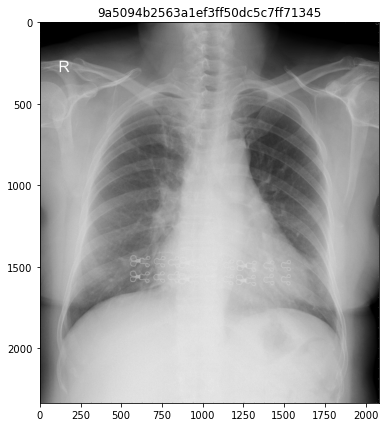

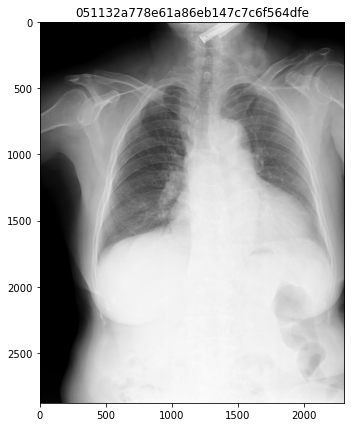

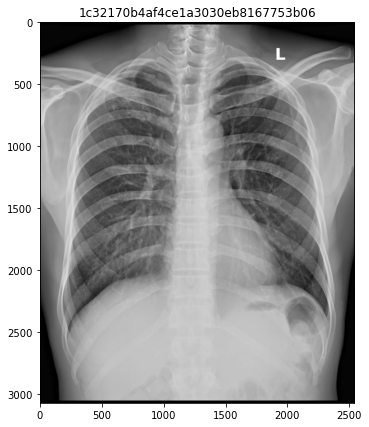

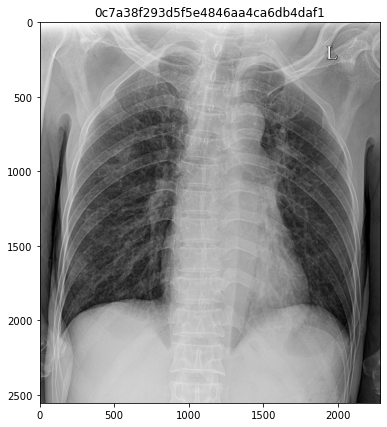

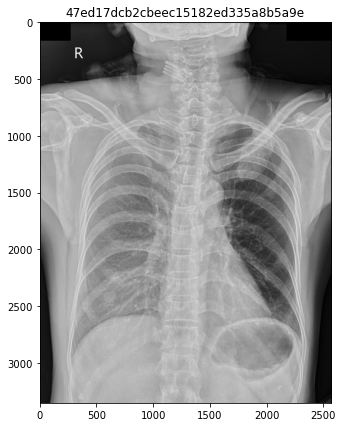

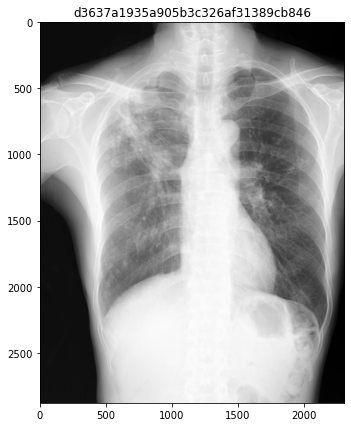

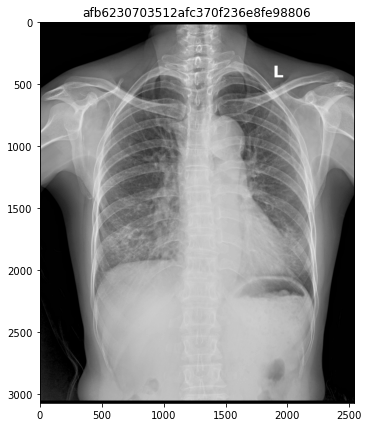

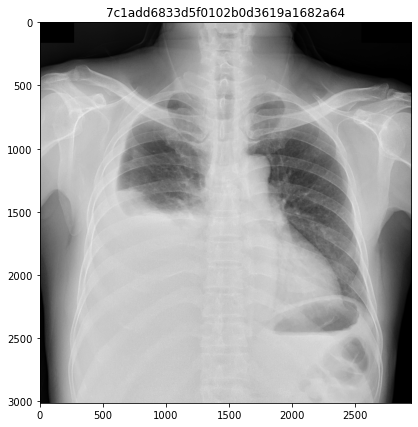

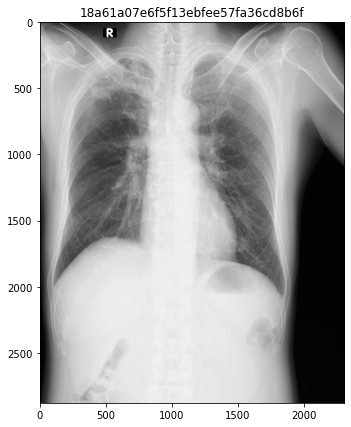

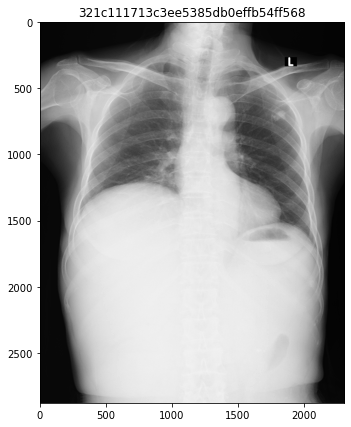

In [11]:
shortlisted_img_ids = img_ids[:10]
og_imgs = [dicom2array(f'{dataset_dir}/train/{path}.dicom') for path in shortlisted_img_ids]

for img_as_arr, img_id in zip(og_imgs, shortlisted_img_ids):
    plot_img(img_as_arr, img_id)

In [12]:
shortlisted_img_ids

array(['9a5094b2563a1ef3ff50dc5c7ff71345',
       '051132a778e61a86eb147c7c6f564dfe',
       '1c32170b4af4ce1a3030eb8167753b06',
       '0c7a38f293d5f5e4846aa4ca6db4daf1',
       '47ed17dcb2cbeec15182ed335a8b5a9e',
       'd3637a1935a905b3c326af31389cb846',
       'afb6230703512afc370f236e8fe98806',
       '7c1add6833d5f0102b0d3619a1682a64',
       '18a61a07e6f5f13ebfee57fa36cd8b6f',
       '321c111713c3ee5385db0effb54ff568'], dtype=object)

In [13]:
finding_df[finding_df["image_id"]=="9a5094b2563a1ef3ff50dc5c7ff71345"]

image_id          class_name  class_id rad_id  \
2      9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
5517   9a5094b2563a1ef3ff50dc5c7ff71345    Pleural effusion        10     R9   
25023  9a5094b2563a1ef3ff50dc5c7ff71345  Pleural thickening        11     R9   
26165  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3     R9   
42709  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3     R8   
53473  9a5094b2563a1ef3ff50dc5c7ff71345  Aortic enlargement         0     R9   

        x_min   y_min   x_max   y_max  
2       691.0  1375.0  1653.0  1831.0  
5517   1789.0  1729.0  1875.0  1992.0  
25023  1789.0  1729.0  1875.0  1992.0  
26165   692.0  1375.0  1657.0  1799.0  
42709   689.0  1313.0  1666.0  1763.0  
53473  1052.0   715.0  1299.0   966.0

# Visualize Bounding Box with Original Image size

In [14]:
def get_bb_info(df, img_id):
    bounding_boxes_info = df.loc[df["image_id"]==img_id, ['x_min', 'y_min', 'x_max', 'y_max', "class_id"]]

    bboxes = []
    for _, row in bounding_boxes_info.astype(np.int16).iterrows():
        bboxes.append(list(row))
    
    return bboxes

In [15]:
# class 14:"No finding"
label2color = { 0:("Aortic enlargement","#2a52be"),
                1:("Atelectasis","#ffa812"),
                2:("Calcification","#ff8243"),
                3:("Cardiomegaly","#4682b4"),
                4:("Consolidation","#ddadaf"),
                5:("ILD","#a3c1ad"),
                6:("Infiltration","#008000"),
                7:("Lung Opacity","#004953"),
                8:("Nodule/Mass","#e3a857"),
                9:("Other lesion","#dda0dd"),
               10:("Pleural effusion","#e6e8fa"),
               11:("Pleural thickening","#800020"),
               12:("Pneumothorax","#918151"),
               13:("Pulmonary fibrosis","#e75480")}

In [16]:
# code to plot image with bounding boxes
def bounding_box_plotter(img_as_arr, img_id, bounding_boxes_info):
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_axes([0,0,1,1])
    
    # plot the image
    plt.imshow(img_as_arr, cmap="gray")
    plt.title(img_id)

    # add the bounding boxes
    for row in bounding_boxes_info:
        # each row contains 'x_min', 'y_min', 'x_max', 'y_max', "class_id"
        xmin = row[0]
        xmax = row[2]
        ymin = row[1]
        ymax = row[3]

        width = xmax - xmin
        height = ymax - ymin

        # assign different color to different classes of objects
        edgecolor = label2color[row[4]][1]
        ax.annotate(label2color[row[4]][0], xy=(xmax - 40, ymin + 20))

        # add bounding boxes to the image
        rect = patches.Rectangle((xmin, ymin), width, height, edgecolor=edgecolor, facecolor='none')

        ax.add_patch(rect)

    plt.show()
    

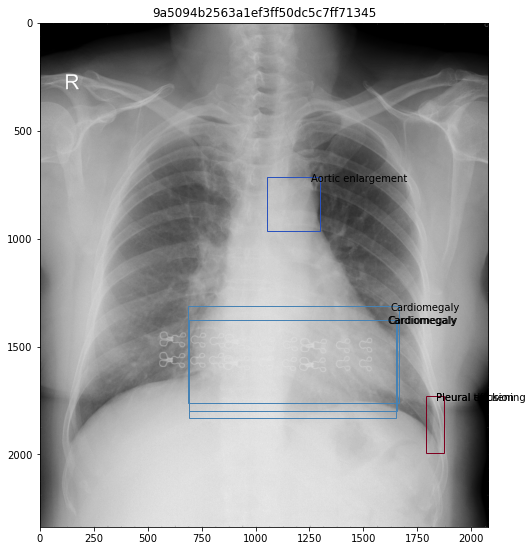

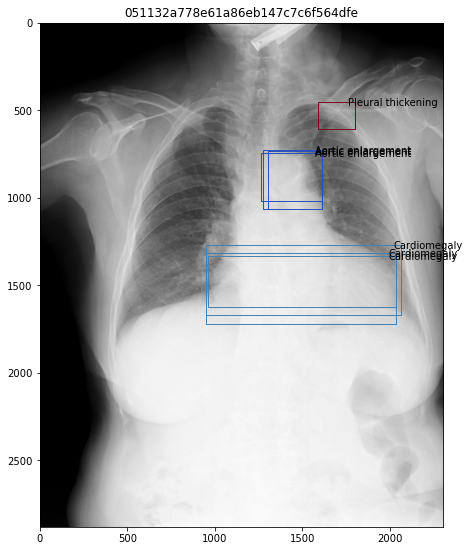

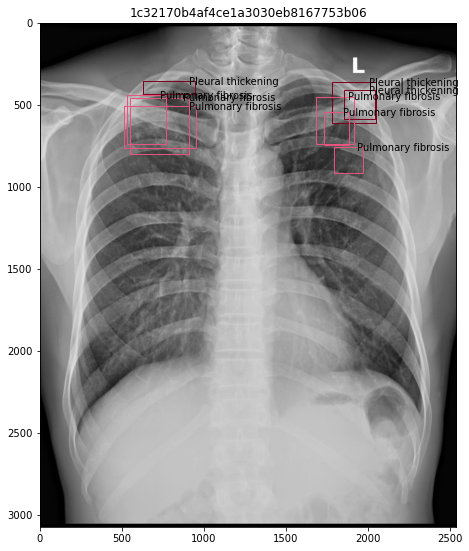

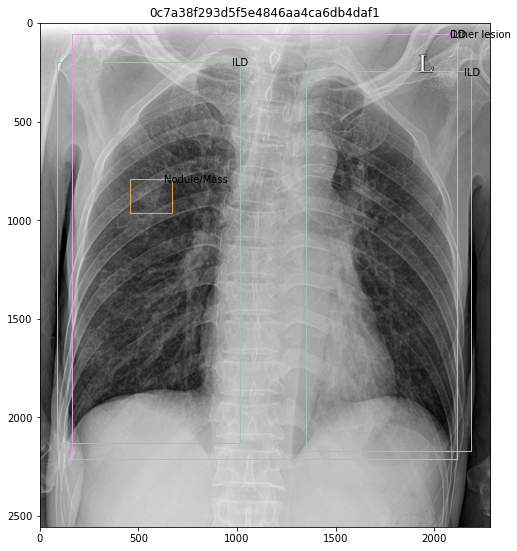

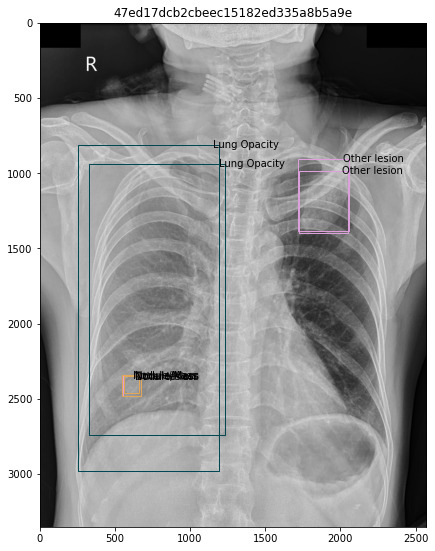

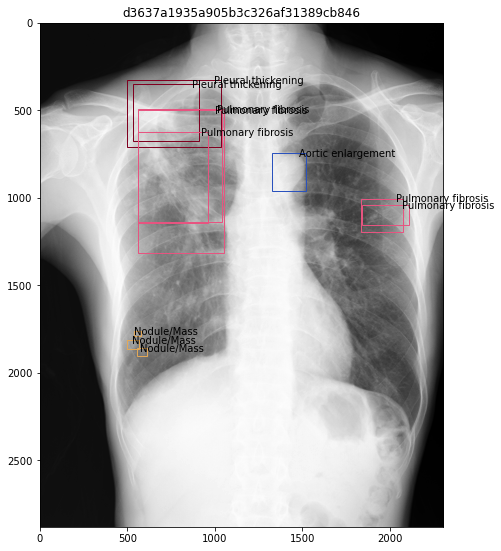

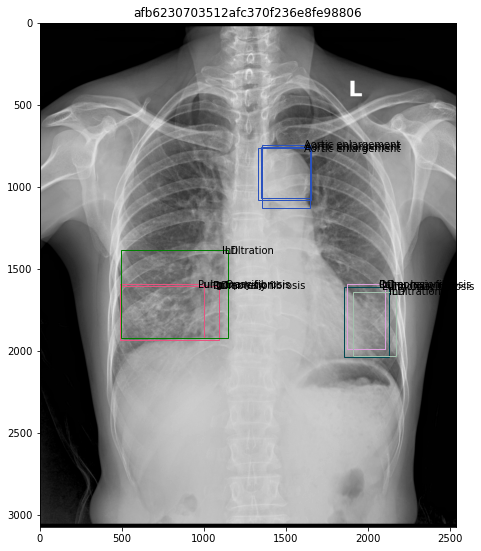

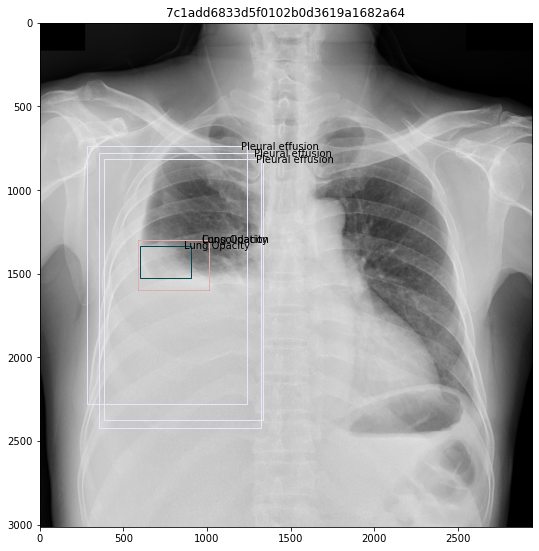

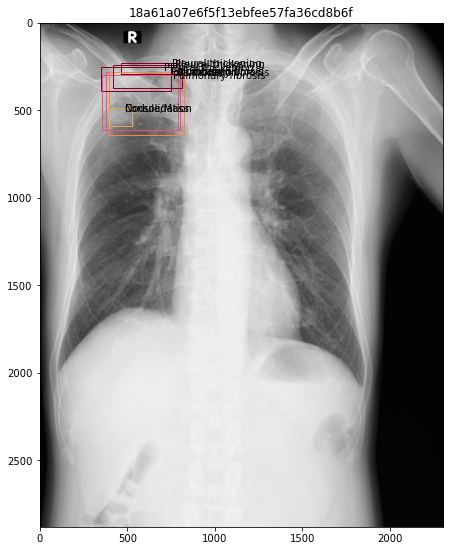

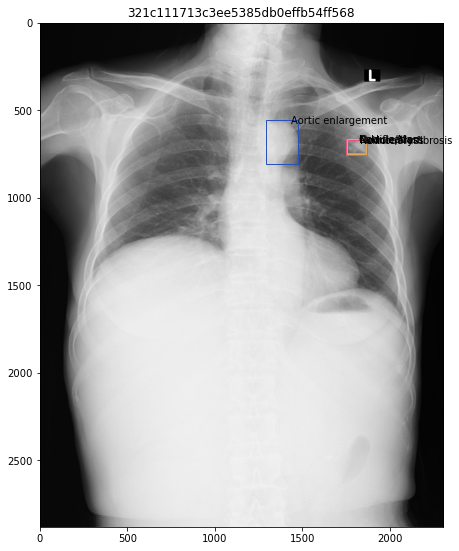

In [17]:
# plotting the original image with the original bounding boxes
for img_as_arr, img_id in zip(og_imgs,shortlisted_img_ids):    
    bounding_boxes_info = get_bb_info(finding_df,    img_id)
    bounding_box_plotter(img_as_arr, img_id, bounding_boxes_info)

##### Resize image and adjust bounding boxes

The original X-ray image is 2336 x 2080. We will use albumentations library to rescale the image to smallest size to be 1024. Thus the aspect ratio of the image will be maintained. Additionally we will also take care of the bounding boxes and verify once the resizing of image is done.

In [18]:
# https://www.kaggle.com/bjoernholzhauer/eda-dicom-reading-vinbigdata-chest-x-ray#7.-Creating-fast-to-read-shelve-file
def resize_image(df, img_arr, image_id):
    
    # create resize transform pipeline
    transform = albumentations.Compose([
        # Faster RCNN needs minimum 800x800 dimension (https://debuggercafe.com/faster-rcnn-object-detection-with-pytorch/)
        albumentations.SmallestMaxSize(max_size=1024, always_apply=True)
    ], bbox_params=albumentations.BboxParams(format='pascal_voc')) 
    
    # each row in bounding boxes will contain 'x_min', 'y_min', 'x_max', 'y_max', "class_id"
    bboxes = get_bb_info(df, image_id)
    
    transformed = transform(image=img_arr, bboxes=bboxes)
    
    return transformed

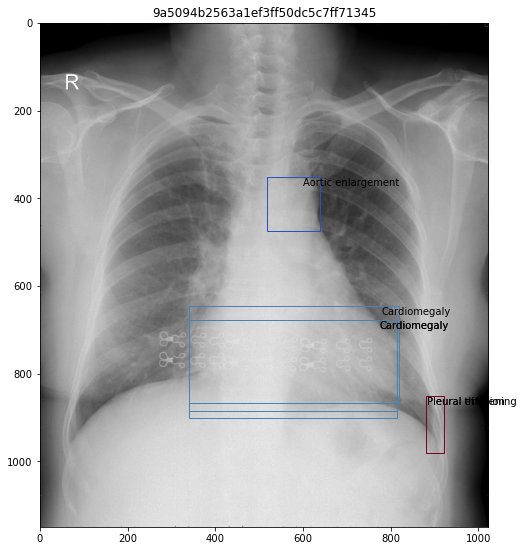

Original Dimension: (2336, 2080)
Transformed Dimension: (1150, 1024)


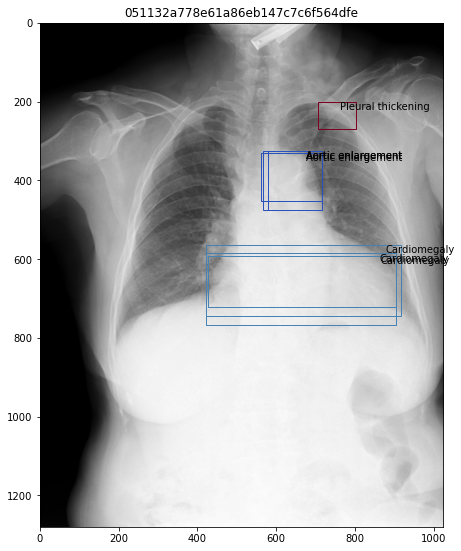

Original Dimension: (2880, 2304)
Transformed Dimension: (1280, 1024)


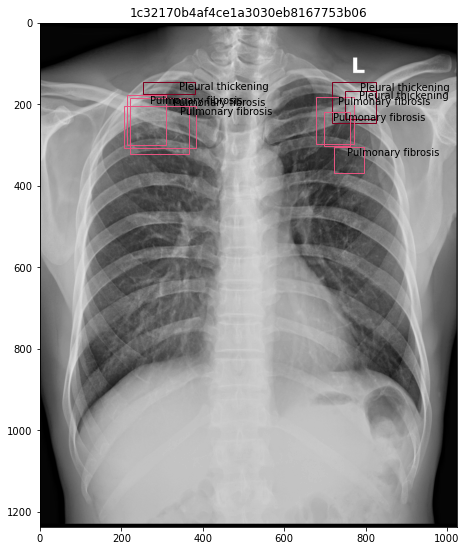

Original Dimension: (3072, 2540)
Transformed Dimension: (1238, 1024)


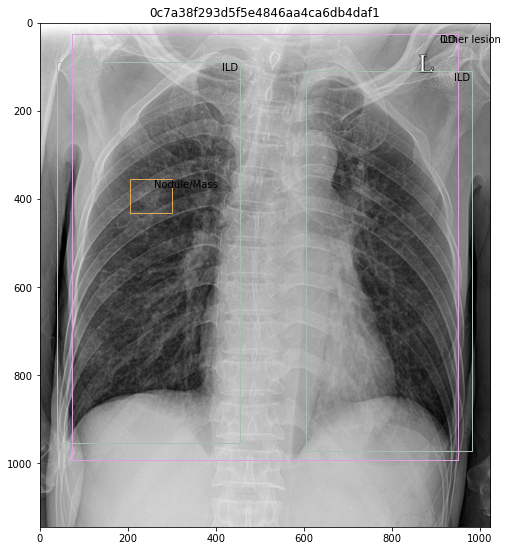

Original Dimension: (2555, 2285)
Transformed Dimension: (1145, 1024)


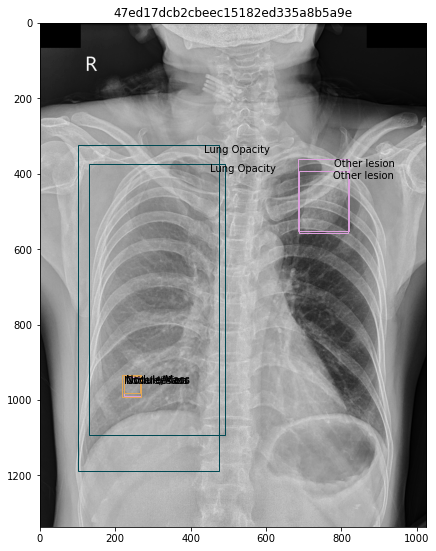

Original Dimension: (3353, 2568)
Transformed Dimension: (1337, 1024)


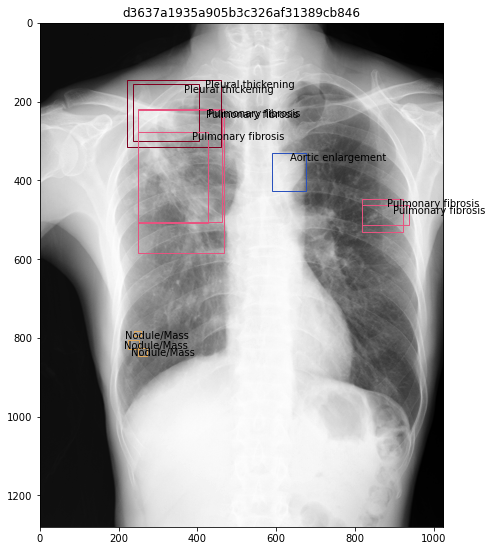

Original Dimension: (2880, 2304)
Transformed Dimension: (1280, 1024)


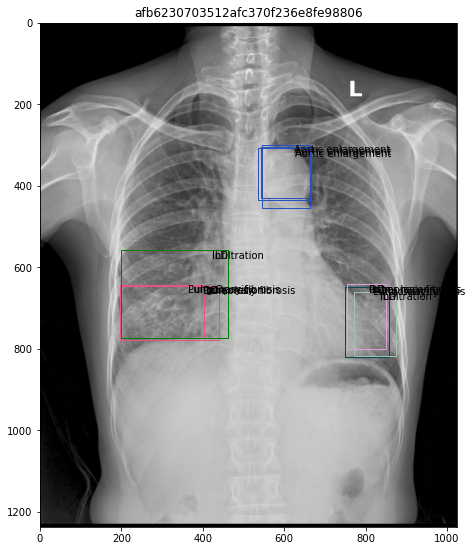

Original Dimension: (3072, 2540)
Transformed Dimension: (1238, 1024)


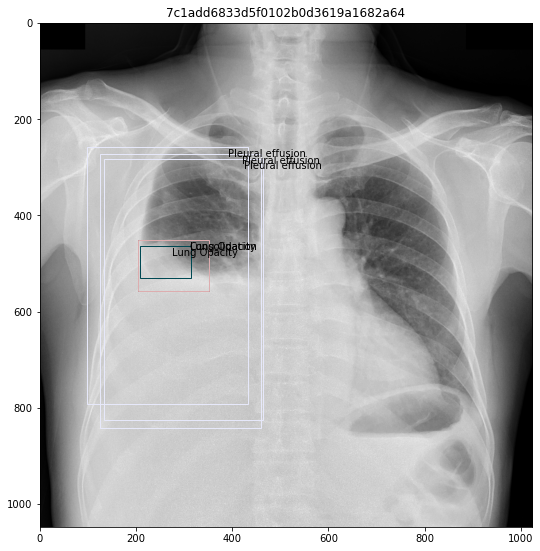

Original Dimension: (3014, 2944)
Transformed Dimension: (1048, 1024)


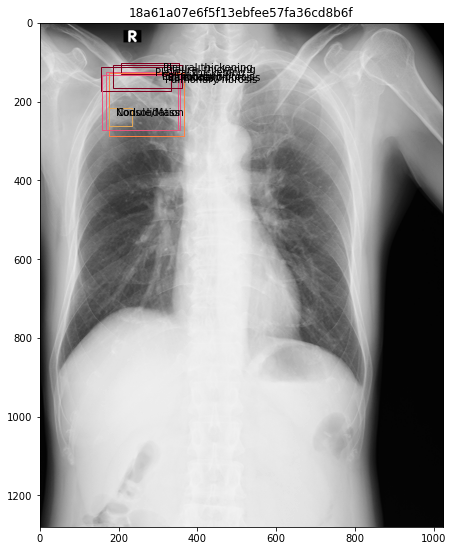

Original Dimension: (2880, 2304)
Transformed Dimension: (1280, 1024)


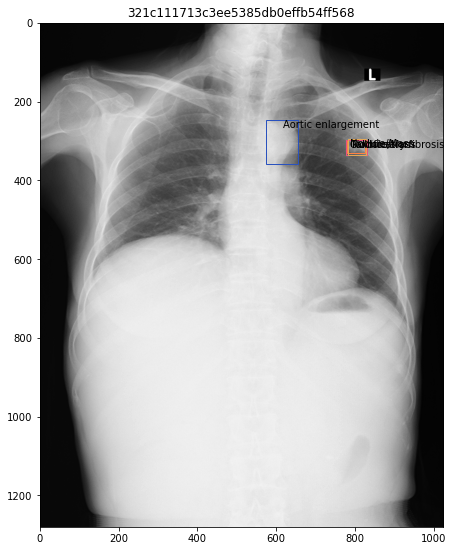

Original Dimension: (2880, 2304)
Transformed Dimension: (1280, 1024)


In [19]:
for img_as_arr, img_id in zip(og_imgs,shortlisted_img_ids):    
    transformed = resize_image(finding_df, img_as_arr, img_id)
    bounding_box_plotter(transformed["image"], img_id, transformed["bboxes"])
    print(f"Original Dimension: {img_as_arr.shape}\nTransformed Dimension: {transformed['image'].shape}")

img_as_arr.shape returns number of rows x number of columns. 

* number of rows --> Height
* number of columns --> Width

# Handle No Finding class

In [20]:
train_df.head()

image_id          class_name  class_id rad_id  \
0  50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1  21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
4  063319de25ce7edb9b1c6b8881290140          No finding        14    R10   

    x_min   y_min   x_max   y_max  
0     NaN     NaN     NaN     NaN  
1     NaN     NaN     NaN     NaN  
2   691.0  1375.0  1653.0  1831.0  
3  1264.0   743.0  1611.0  1019.0  
4     NaN     NaN     NaN     NaN

In [21]:
values = {'x_min': 0, 'y_min': 0, 'x_max': 1, 'y_max': 1}
train_df = train_df.fillna(value=values)

In [22]:
train_df.head()

image_id          class_name  class_id rad_id  \
0  50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1  21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
4  063319de25ce7edb9b1c6b8881290140          No finding        14    R10   

    x_min   y_min   x_max   y_max  
0     0.0     0.0     1.0     1.0  
1     0.0     0.0     1.0     1.0  
2   691.0  1375.0  1653.0  1831.0  
3  1264.0   743.0  1611.0  1019.0  
4     0.0     0.0     1.0     1.0

# Resize all data and prep Bounding Box CSV file

In [23]:
# create train directory
transformed_trained_dir = f"{output_dir}/transformed_data/train"
os.makedirs(transformed_trained_dir, exist_ok=True)

# create test directory
transformed_test_dir = f"{output_dir}/transformed_data/test"
os.makedirs(transformed_test_dir, exist_ok=True)

**Train Data**

Original Columns:
* image_id	
* class_name	
* class_id	
* rad_id	
* x_min	
* y_min	
* x_max	
* y_max

In [24]:
train_df.head()

image_id          class_name  class_id rad_id  \
0  50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1  21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
4  063319de25ce7edb9b1c6b8881290140          No finding        14    R10   

    x_min   y_min   x_max   y_max  
0     0.0     0.0     1.0     1.0  
1     0.0     0.0     1.0     1.0  
2   691.0  1375.0  1653.0  1831.0  
3  1264.0   743.0  1611.0  1019.0  
4     0.0     0.0     1.0     1.0

In [25]:
train_df["image_id"].unique()

array(['50a418190bc3fb1ef1633bf9678929b3',
       '21a10246a5ec7af151081d0cd6d65dc9',
       '9a5094b2563a1ef3ff50dc5c7ff71345', ...,
       '1bea772246421c37929f8cbc43dba729',
       'ae86eabab95525b41b8e79883ff1cef9',
       '839b2311ffad9bdd9aa98c74aad6e251'], dtype=object)

In [26]:
def get_info(df, image_id, columns_arr):
    info_row = df.loc[df["image_id"]==image_id, columns_arr]

    info = []
    for _, row in info_row.iterrows():
        info.append(list(row))
    
    return info

In [27]:
# https://www.kaggle.com/bjoernholzhauer/eda-dicom-reading-vinbigdata-chest-x-ray#7.-Creating-fast-to-read-shelve-file
def generic_resize_image(df, image_id, image_path, transform_bb=True):
        
    # convert dicom to array
    img_arr = dicom2array(image_path)
    im_pil = Image.fromarray(img_arr)
    
    # training data
    if transform_bb:
        # create resize transform pipeline
        transform = albumentations.Compose([
            albumentations.SmallestMaxSize(max_size=1024, always_apply=True)
        ], bbox_params=albumentations.BboxParams(format='pascal_voc')) 

        columns = ["x_min", "y_min", "x_max","y_max","class_id","class_name","rad_id"]
        bboxes = get_info(df, image_id, columns)

        transformed = transform(image=img_arr, bboxes=bboxes)
    else:
        # create resize transform pipeline
        transform = albumentations.Compose([
            albumentations.SmallestMaxSize(max_size=1024, always_apply=True)
        ]) 

        transformed = transform(image=img_arr)

    # im_pil.size[0] = width, im_pil.size[1] = height
    return transformed, im_pil.size[0], im_pil.size[1]

In [28]:
# list for resized train data
image_id = []
x_min = []
y_min = []
x_max = []
y_max = []
class_id = []
class_name = []
rad_id = []
original_width = []
original_height = []
transformed_width = []
transformed_height = []

# start time
start = datetime.now()

# conversion
for img_id in train_df["image_id"].unique():        
    transformed, width, height = generic_resize_image(train_df, img_id, f"{dataset_dir}/train/{img_id}.dicom")
    
    # save image array as jpeg
    im = Image.fromarray(transformed["image"])
    im.save(transformed_trained_dir+f"/{img_id}.jpeg")
    
    for i in range(len(transformed["bboxes"])):
        image_id.append(img_id)
        # each row contains "x_min", "y_min", "x_max","y_max","class_id","class_name","rad_id"
        x_min.append(transformed["bboxes"][i][0])
        y_min.append(transformed["bboxes"][i][1])
        x_max.append(transformed["bboxes"][i][2])
        y_max.append(transformed["bboxes"][i][3])
        class_id.append(transformed["bboxes"][i][4])
        class_name.append(transformed["bboxes"][i][5])
        rad_id.append(transformed["bboxes"][i][6])
        original_width.append(width)
        original_height.append(height)
        # when using size we get width x height
        transformed_width.append(im.size[0])
        transformed_height.append(im.size[1])
    
    
    
updated_csv = pd.DataFrame({
    "image_id":image_id,
    "x_min":x_min,
    "y_min":y_min,
    "x_max":x_max,
    "y_max":y_max,
    "class_id":class_id,
    "class_name":class_name,
    "rad_id":rad_id,
    "original_width":original_width,
    "original_height":original_height,
    "transformed_width":transformed_width,
    "transformed_height":transformed_height
})
updated_csv.to_csv(f"{transformed_trained_dir}/transformed_train.csv", index=False)

# end time
print("End time:"+str(datetime.now() - start))

End time:5:48:33.167244


### Verfiy train data with shortlisted ids

In [29]:
verifier_csv = pd.read_csv(f"{transformed_trained_dir}/transformed_train.csv")

In [30]:
shortlisted_img_ids

array(['9a5094b2563a1ef3ff50dc5c7ff71345',
       '051132a778e61a86eb147c7c6f564dfe',
       '1c32170b4af4ce1a3030eb8167753b06',
       '0c7a38f293d5f5e4846aa4ca6db4daf1',
       '47ed17dcb2cbeec15182ed335a8b5a9e',
       'd3637a1935a905b3c326af31389cb846',
       'afb6230703512afc370f236e8fe98806',
       '7c1add6833d5f0102b0d3619a1682a64',
       '18a61a07e6f5f13ebfee57fa36cd8b6f',
       '321c111713c3ee5385db0effb54ff568'], dtype=object)

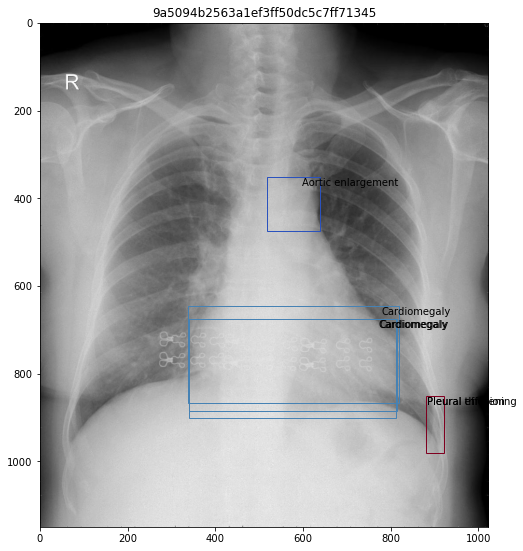

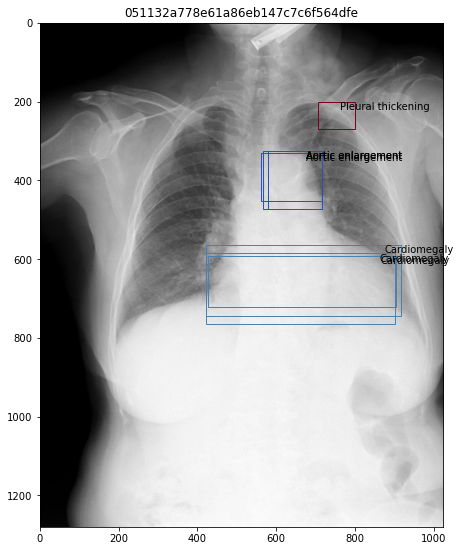

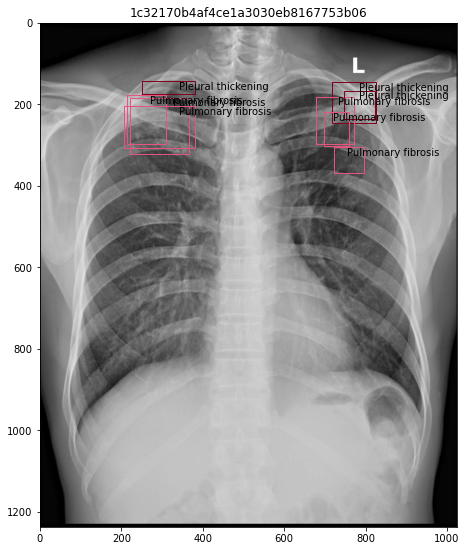

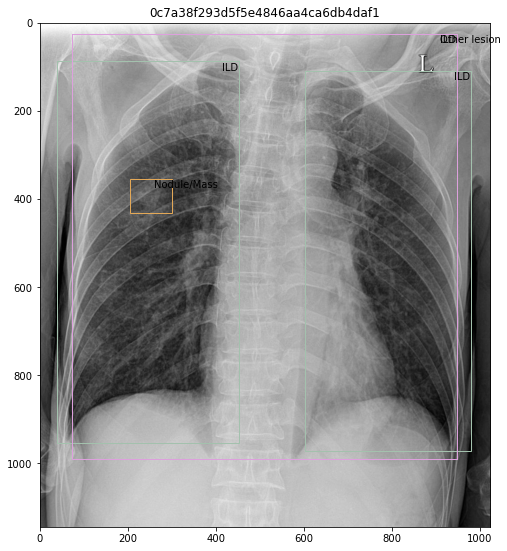

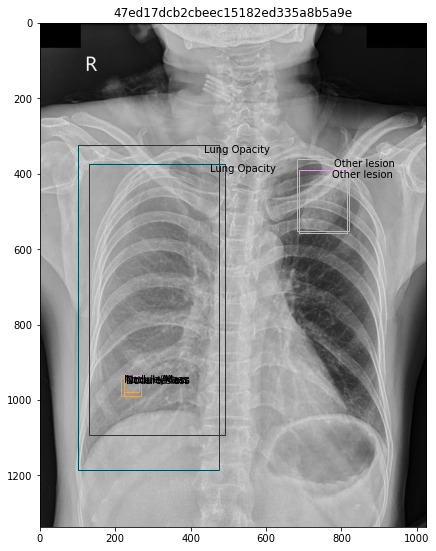

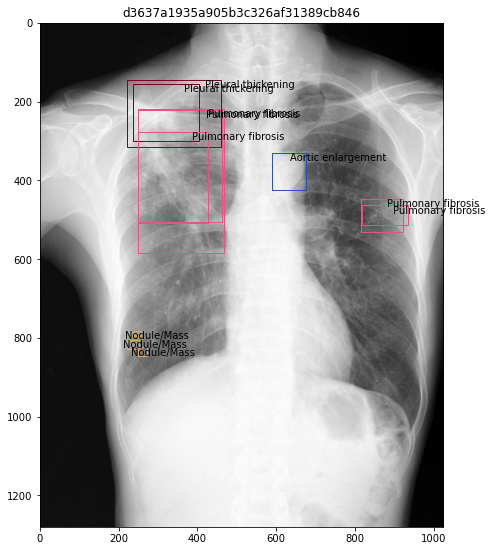

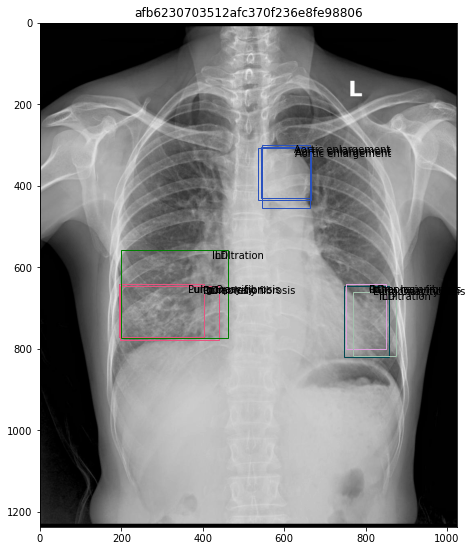

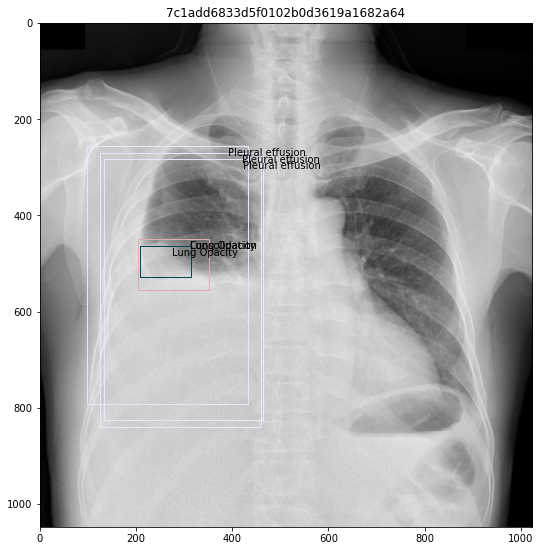

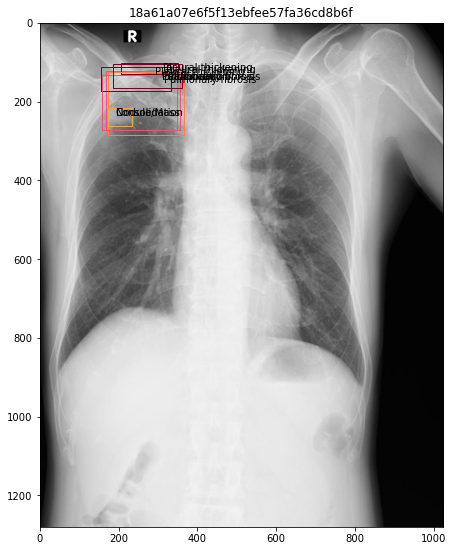

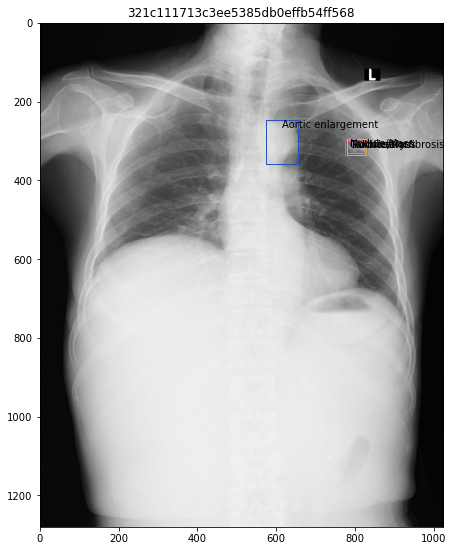

In [31]:
for img_id in shortlisted_img_ids:    
    bounding_boxes_info = get_bb_info(verifier_csv,img_id)
    
    # read image as array
    im = Image.open(transformed_trained_dir+f"/{img_id}.jpeg")
    bounding_box_plotter(im, img_id, bounding_boxes_info)

**Test Data**

In [32]:
test_ids = []
for f in sorted(os.listdir(f"{dataset_dir}/test/")):
    test_ids.append(f)

In [33]:
# start time
start = datetime.now()

original_width = []
original_height = []
transformed_width = []
transformed_height = []
image_id = []

# conversion
for file_name in test_ids:        
    transformed, width, height = generic_resize_image(None, None, f"{dataset_dir}/test/{file_name}", False)
    
    image_id.append(file_name[:-6])
    original_width.append(width)
    original_height.append(height)
    
    # save image array as jpeg
    im = Image.fromarray(transformed["image"])
    im.save(transformed_test_dir+f"/{file_name[:-6]}.jpeg")
    
    # when using size we get width x height
    transformed_width.append(im.size[0])
    transformed_height.append(im.size[1])
    
test_csv = pd.DataFrame({
    "image_id":image_id,
    "original_width":original_width,
    "original_height":original_height,
    "transformed_width":transformed_width,
    "transformed_height":transformed_height
})
test_csv.to_csv(f"{transformed_test_dir}/test_original_dimension.csv", index=False)
    
# end time
print("End time:"+str(datetime.now() - start))

End time:1:09:15.625083


In [34]:
view_DICOM_metadata("009bc039326338823ca3aa84381f17f1", test_data=True)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 156
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 009bc039326338823ca3aa84381f17f1
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: ''
(0002, 0016) Source Application Entity Title     AE: 'VITREA1'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'O'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 2430
(0028, 0011) Columns                             US: 1994
(0028, 0030) Pixel Spacing            